In [1]:
import matplotlib.pyplot as plt
from datetime import datetime, time
from dateutil.relativedelta import relativedelta
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ta, os, re, warnings
import mplfinance as mpf
from itertools import product
import numpy as np

from tqdm import tqdm

In [2]:
from src.DataUpdateModule import DataUpdateModule
from src.Strategy import Strategy
from src.DayTrade import DayTrade
DUM = DataUpdateModule(options_interval_minutes = 5)
strategy = Strategy()
strategy.params_grid

{'fast': [20, 30],
 'slow_mult': [3],
 'rsi_threshold': [70],
 'opt_leg1_dollar_from_atm': [2, 5],
 'opt_leg2_dollar_from_leg1': [5, 10],
 'stoploss_pct_of_maxprofit': [0.1, 0.5, 1.0]}

In [3]:
# Find list of available data
available_data = list()
for x in os.listdir("./data/"):
    date = re.search(r"\d{8}", x).group(0)
    date = datetime(int(date[:4]), int(date[4:6]), int(date[6:]))
    available_data.append(date)
available_data_counts = pd.Series(available_data).value_counts()
available_data = available_data_counts[available_data_counts == 2].index.tolist()

## Main walk-fwd test

In [4]:
commission_dollars = .15
trading_months = [datetime(2022, 2, 1) + relativedelta(months = x) for x in range(45)]

In [5]:
AUM = 6.5 * 1e6
DAYs = [pd.NA]
MODELs = [pd.NA]
PNLs = [pd.NA]
AUMs = [AUM]

all_actual_trades = list()
trade_summary = list()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for trade_month in trading_months:
        print(f"===== {trade_month} =====")
        # Find best model in past month
        past_month = trade_month - relativedelta(months = 1)
        trade_days = [x for x in available_data if x.year == past_month.year and x.month == past_month.month]

        ## trade
        models_AUM = [AUM] * len(strategy.get_models())
        all_all_trades = list()
        for trade_day in trade_days:
            df_stock, df_options = DUM.read_data(trade_day)
            strategy.compute_tech_indicators(df_stock)
            all_trades = list()
            for model_num in tqdm(range(len(strategy.get_models()))):
                DT = DayTrade(strategy, model_num = model_num, AUM = models_AUM[model_num], df_options = df_options, commission_dollars = commission_dollars, max_risk = 0.025, interval = 5)
                trades = DT.trade()
                models_AUM[model_num] += trades.loc[:, "pnl"].sum() if len(trades) > 0 else 0
                all_trades.append(trades)
            param_pnl = pd.DataFrame([strategy.get_models(x) | {"pnl" : all_trades[x]["pnl"].sum(), "model_num" : x} for x in range(len(all_trades))]).assign(day = trade_day)
            all_all_trades.append(param_pnl)
        all_all_trades = pd.concat(all_all_trades)
        # all_all_trades.to_csv(f"./results/past_mth_test_{past_month.strftime('%Y-%m')}.csv")
        ## best model
        ratio = dict()
        for model_num in all_all_trades.loc[:, "model_num"].unique():
            df_plot = all_all_trades[all_all_trades.loc[:, "model_num"] == model_num]
            ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()
        model_rankings = pd.Series(ratio).replace([np.inf, -np.inf], np.nan).sort_values(ascending = False)
        # model_rankings.to_csv(f"./results/past_mth_test_rankings_{past_month.strftime('%Y-%m')}.csv")
        best_model = model_rankings.index[0]
        print(f"Model selected from {past_month.strftime('%Y-%m')}: {best_model}:{round(model_rankings.iloc[0], 3)}")

        # Actual trading
        trade_days = [x for x in available_data if x.year == trade_month.year and x.month == trade_month.month]

        for trade_day in trade_days:
            # Get information
            df_stock, df_options = DUM.read_data(trade_day)
            strategy.compute_tech_indicators(df_stock)

            # Trade
            DT = DayTrade(strategy, model_num = best_model, AUM = AUMs[-1], df_options = df_options, commission_dollars = commission_dollars, max_risk = 0.025, interval = 5)
            trades = DT.trade()
            pnl = trades.loc[:, "pnl"].sum() if len(trades) > 0 else 0
            AUM = AUMs[-1] + pnl

            # Saving data
            DAYs.append(trade_day)
            MODELs.append(best_model)
            PNLs.append(pnl)
            AUMs.append(AUM)
            all_actual_trades.append(trades)
            trade_summary.append(strategy.get_models(best_model) | {"pnl" : trades.loc[:, "pnl"].sum(), "model_num" : best_model, "day" : trade_day})

            # Print
            print(f"{trade_day.strftime('%Y-%m-%d')} : AUM = {format(round(AUM), ",")}")

    trade_summary = pd.DataFrame(trade_summary)
    # trade_summary.to_csv(f"./results/trade_summary")
    all_actual_trades = pd.concat(all_actual_trades)
    # all_actual_trades.to_csv(f"./results/trading_mth_test_{trade_month.strftime('%Y-%m')}.csv")

===== 2022-02-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.68it/s]


Model selected from 2022-01: 12:0.544
2022-02-04 : AUM = 6,499,259
2022-02-11 : AUM = 6,471,756
2022-02-18 : AUM = 6,467,610
2022-02-25 : AUM = 6,467,596
===== 2022-03-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.58it/s]


Model selected from 2022-02: 2:1.013
2022-03-04 : AUM = 6,464,810
2022-03-11 : AUM = 6,493,525
2022-03-18 : AUM = 6,520,166
2022-03-25 : AUM = 6,529,798
===== 2022-04-01 00:00:00 =====


100%|██████████| 24/24 [00:04<00:00,  5.30it/s]


Model selected from 2022-03: 17:2.254
2022-04-01 : AUM = 6,539,427
2022-04-08 : AUM = 6,526,255
2022-04-22 : AUM = 6,539,134
2022-04-29 : AUM = 6,561,232
===== 2022-05-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.41it/s]


Model selected from 2022-04: 23:0.661
2022-05-06 : AUM = 6,574,910
2022-05-13 : AUM = 6,571,469
2022-05-20 : AUM = 6,578,931
2022-05-27 : AUM = 6,584,230
===== 2022-06-01 00:00:00 =====


100%|██████████| 24/24 [00:04<00:00,  5.99it/s]


Model selected from 2022-05: 23:0.807
2022-06-03 : AUM = 6,589,958
2022-06-10 : AUM = 6,594,366
2022-06-17 : AUM = 6,587,647
2022-06-24 : AUM = 6,589,690
===== 2022-07-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.05it/s]


Model selected from 2022-06: 9:1.009
2022-07-01 : AUM = 6,586,236
2022-07-08 : AUM = 6,585,195
2022-07-15 : AUM = 6,584,961
2022-07-22 : AUM = 6,584,255
2022-07-29 : AUM = 6,586,555
===== 2022-08-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.27it/s]


Model selected from 2022-07: 17:1.189
2022-08-05 : AUM = 6,593,158
2022-08-12 : AUM = 6,601,395
2022-08-19 : AUM = 6,598,493
2022-08-26 : AUM = 6,620,744
===== 2022-09-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.70it/s]


Model selected from 2022-08: 1:1.408
2022-09-02 : AUM = 6,610,891
2022-09-09 : AUM = 6,627,021
2022-09-16 : AUM = 6,652,482
2022-09-23 : AUM = 6,665,731
2022-09-30 : AUM = 6,644,608
===== 2022-10-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.88it/s]


Model selected from 2022-09: 23:0.464
2022-10-07 : AUM = 6,650,380
2022-10-14 : AUM = 6,657,375
2022-10-21 : AUM = 6,662,887
2022-10-28 : AUM = 6,688,769
===== 2022-11-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.71it/s]


Model selected from 2022-10: 13:1.417
2022-11-04 : AUM = 6,759,348
2022-11-11 : AUM = 6,729,723
2022-11-18 : AUM = 6,745,308
2022-11-25 : AUM = 6,748,002
===== 2022-12-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00, 11.64it/s]


Model selected from 2022-11: 1:0.849
2022-12-02 : AUM = 6,765,681
2022-12-09 : AUM = 6,785,269
2022-12-16 : AUM = 6,784,655
2022-12-23 : AUM = 6,768,937
2022-12-30 : AUM = 6,823,833
===== 2023-01-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.26it/s]


Model selected from 2022-12: 11:0.579
2023-01-06 : AUM = 6,820,479
2023-01-13 : AUM = 6,821,772
2023-01-20 : AUM = 6,826,313
2023-01-27 : AUM = 6,828,055
===== 2023-02-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.32it/s]


Model selected from 2023-01: 22:1.561
2023-02-03 : AUM = 6,827,105
2023-02-10 : AUM = 6,829,740
2023-02-17 : AUM = 6,832,020
2023-02-24 : AUM = 6,833,775
===== 2023-03-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.92it/s]


Model selected from 2023-02: 8:6.578
2023-03-03 : AUM = 6,835,105
2023-03-10 : AUM = 6,855,190
2023-03-17 : AUM = 6,853,754
2023-03-24 : AUM = 6,854,172
2023-03-31 : AUM = 6,855,056
===== 2023-04-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.76it/s]


Model selected from 2023-03: 14:0.971
2023-04-14 : AUM = 6,854,705
2023-04-21 : AUM = 6,847,203
2023-04-28 : AUM = 6,854,112
===== 2023-05-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.58it/s]


Model selected from 2023-04: 12:0.119
2023-05-05 : AUM = 6,864,546
2023-05-12 : AUM = 6,863,055
2023-05-19 : AUM = 6,857,001
2023-05-26 : AUM = 6,868,033
===== 2023-06-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.35it/s]


Model selected from 2023-05: 13:5.655
2023-06-02 : AUM = 6,883,177
2023-06-09 : AUM = 6,897,454
2023-06-16 : AUM = 6,890,795
2023-06-23 : AUM = 6,958,444
2023-06-30 : AUM = 6,965,178
===== 2023-07-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.79it/s]


Model selected from 2023-06: 5:1.102
2023-07-07 : AUM = 6,968,157
2023-07-21 : AUM = 6,970,339
2023-07-28 : AUM = 6,971,257
===== 2023-08-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.38it/s]


Model selected from 2023-07: 3:8.195
2023-08-04 : AUM = 6,962,742
2023-08-11 : AUM = 6,976,115
2023-08-18 : AUM = 6,976,348
2023-08-25 : AUM = 6,964,805
===== 2023-09-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.41it/s]


Model selected from 2023-08: 6:0.066
2023-09-01 : AUM = 6,964,805
2023-09-08 : AUM = 6,964,805
2023-09-15 : AUM = 6,969,537
2023-09-22 : AUM = 6,969,537
2023-09-29 : AUM = 6,969,537
===== 2023-10-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.63it/s]


Model selected from 2023-09: 5:1.346
2023-10-06 : AUM = 6,980,028
2023-10-13 : AUM = 6,968,897
2023-10-20 : AUM = 6,952,889
2023-10-27 : AUM = 6,964,732
===== 2023-11-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.42it/s]


Model selected from 2023-10: 12:1.409
2023-11-03 : AUM = 6,967,723
2023-11-10 : AUM = 6,959,215
2023-11-17 : AUM = 6,964,825
2023-11-24 : AUM = 6,964,825
===== 2023-12-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00, 10.09it/s]


Model selected from 2023-11: 4:1.091
2023-12-01 : AUM = 6,969,199
2023-12-08 : AUM = 6,966,002
2023-12-15 : AUM = 6,970,916
2023-12-22 : AUM = 6,964,806
2023-12-29 : AUM = 6,972,645
===== 2024-01-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.26it/s]


Model selected from 2023-12: 15:0.496
2024-01-05 : AUM = 6,971,612
2024-01-12 : AUM = 6,959,704
2024-01-19 : AUM = 6,958,043
2024-01-26 : AUM = 6,956,214
===== 2024-02-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.85it/s]


Model selected from 2024-01: 4:0.556
2024-02-02 : AUM = 6,962,116
2024-02-09 : AUM = 6,958,873
2024-02-16 : AUM = 6,963,112
2024-02-23 : AUM = 6,978,459
===== 2024-03-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.35it/s]


Model selected from 2024-02: 0:0.79
2024-03-01 : AUM = 6,995,507
2024-03-08 : AUM = 6,991,849
2024-03-15 : AUM = 6,993,902
2024-03-22 : AUM = 6,993,911
===== 2024-04-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.24it/s]


Model selected from 2024-03: 8:1.146
2024-04-05 : AUM = 6,998,952
2024-04-26 : AUM = 7,001,422
===== 2024-05-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.19it/s]


Model selected from 2024-04: 15:77.454
2024-05-03 : AUM = 6,992,221
2024-05-10 : AUM = 6,993,644
2024-05-17 : AUM = 6,999,771
2024-05-24 : AUM = 7,018,131
2024-05-31 : AUM = 7,019,166
===== 2024-06-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.82it/s]


Model selected from 2024-05: 5:1.911
2024-06-07 : AUM = 7,027,062
2024-06-14 : AUM = 7,018,333
2024-06-21 : AUM = 7,022,875
2024-06-28 : AUM = 7,008,743
===== 2024-07-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.93it/s]


Model selected from 2024-06: 3:0.128
2024-07-05 : AUM = 7,009,765
2024-07-12 : AUM = 7,022,351
2024-07-19 : AUM = 7,042,476
2024-07-26 : AUM = 7,050,301
===== 2024-08-01 00:00:00 =====


100%|██████████| 24/24 [00:04<00:00,  5.95it/s]


Model selected from 2024-07: 9:1.309
2024-08-02 : AUM = 7,045,767
2024-08-09 : AUM = 7,040,278
2024-08-16 : AUM = 7,043,224
2024-08-23 : AUM = 7,037,356
2024-08-30 : AUM = 7,044,362
===== 2024-09-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.75it/s]


Model selected from 2024-08: 23:0.759
2024-09-06 : AUM = 7,040,703
2024-09-13 : AUM = 7,042,767
2024-09-20 : AUM = 7,047,891
2024-09-27 : AUM = 7,046,614
===== 2024-10-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.23it/s]


Model selected from 2024-09: 1:1.553
2024-10-04 : AUM = 7,066,692
2024-10-11 : AUM = 7,057,550
2024-10-18 : AUM = 7,052,185
2024-10-25 : AUM = 7,048,901
===== 2024-11-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.00it/s]


Model selected from 2024-10: 13:0.114
2024-11-01 : AUM = 7,021,677
2024-11-08 : AUM = 7,030,814
2024-11-15 : AUM = 7,091,570
2024-11-22 : AUM = 7,109,966
===== 2024-12-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.24it/s]


Model selected from 2024-11: 11:1.877
2024-12-06 : AUM = 7,110,285
2024-12-13 : AUM = 7,109,807
2024-12-20 : AUM = 7,117,503
2024-12-27 : AUM = 7,111,169
===== 2025-01-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.15it/s]


Model selected from 2024-12: 12:2.043
2025-01-03 : AUM = 7,118,824
2025-01-10 : AUM = 7,141,037
2025-01-17 : AUM = 7,154,864
2025-01-24 : AUM = 7,142,384
2025-01-31 : AUM = 7,145,101
===== 2025-02-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.95it/s]


Model selected from 2025-01: 15:0.666
2025-02-07 : AUM = 7,118,386
2025-02-14 : AUM = 7,129,464
2025-02-21 : AUM = 7,130,321
2025-02-28 : AUM = 7,105,214
===== 2025-03-01 00:00:00 =====


100%|██████████| 24/24 [00:04<00:00,  6.00it/s]


Model selected from 2025-02: 11:0.241
2025-03-07 : AUM = 7,078,188
2025-03-14 : AUM = 7,075,275
2025-03-21 : AUM = 7,085,628
2025-03-28 : AUM = 7,070,979
===== 2025-04-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.56it/s]


Model selected from 2025-03: 21:0.343
2025-04-04 : AUM = 7,042,450
2025-04-11 : AUM = 7,021,911
2025-04-25 : AUM = 7,017,801
===== 2025-05-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.05it/s]


Model selected from 2025-04: 4:0.604
2025-05-02 : AUM = 7,012,011
2025-05-09 : AUM = 7,025,264
2025-05-16 : AUM = 7,023,033
2025-05-23 : AUM = 7,044,808
2025-05-30 : AUM = 7,020,602
===== 2025-06-01 00:00:00 =====


100%|██████████| 24/24 [00:04<00:00,  5.98it/s]


Model selected from 2025-05: 3:0.229
2025-06-06 : AUM = 7,013,024
2025-06-13 : AUM = 7,005,904
2025-06-20 : AUM = 6,993,594
2025-06-27 : AUM = 6,991,457
===== 2025-07-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.15it/s]


Model selected from 2025-06: 11:0.647
2025-07-11 : AUM = 6,992,038
2025-07-18 : AUM = 6,996,277
2025-07-25 : AUM = 6,996,858
===== 2025-08-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.21it/s]


Model selected from 2025-07: 11:0.85
2025-08-01 : AUM = 7,004,089
2025-08-08 : AUM = 7,010,035
2025-08-15 : AUM = 7,010,385
2025-08-22 : AUM = 7,027,568
2025-08-29 : AUM = 7,027,752
===== 2025-09-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.98it/s]


Model selected from 2025-08: 0:1.426
2025-09-05 : AUM = 7,036,607
2025-09-12 : AUM = 7,034,779
2025-09-19 : AUM = 7,075,634
2025-09-26 : AUM = 7,046,107
===== 2025-10-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.96it/s]


Model selected from 2025-09: 6:0.5
2025-10-03 : AUM = 7,046,107
2025-10-10 : AUM = 7,004,043
2025-10-17 : AUM = 6,996,390
2025-10-24 : AUM = 6,995,407
2025-10-31 : AUM = 7,000,430


(-5.0, 20.0)

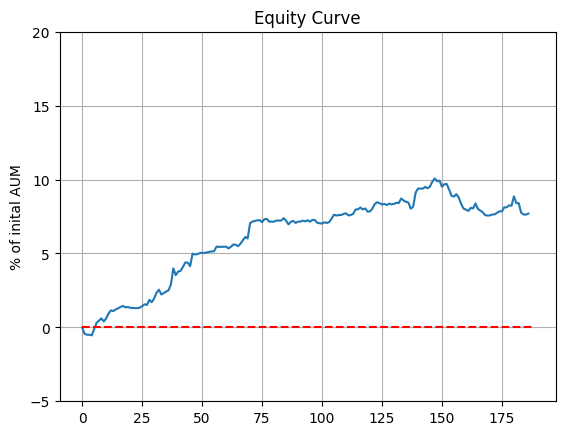

In [6]:
plt.title("Equity Curve")
plt.grid()
plt.plot(pd.Series(PNLs).dropna().cumsum().values.astype(float) / (6.5 * 1e6) * 100)
plt.hlines(y = 0, xmin = 0, xmax = len(PNLs), linestyle = "--", color = "red")
plt.ylabel("% of inital AUM")
plt.ylim(-5, 20)

## With -10c commission


In [7]:
commission_dollars = -.1
trading_months = [datetime(2022, 2, 1) + relativedelta(months = x) for x in range(45)]

In [8]:
AUM = 6.5 * 1e6
DAYs2 = [pd.NA]
MODELs2 = [pd.NA]
PNLs2 = [pd.NA]
AUMs2 = [AUM]

all_actual_trades2 = list()
trade_summary2 = list()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for trade_month in trading_months:
        print(f"===== {trade_month} =====")
        # Find best model in past month
        past_month = trade_month - relativedelta(months = 1)
        trade_days2 = [x for x in available_data if x.year == past_month.year and x.month == past_month.month]

        ## trade
        models2_AUM = [AUM] * len(strategy.get_models())
        all_all_trades = list()
        for trade_day in trade_days2:
            df_stock, df_options = DUM.read_data(trade_day)
            strategy.compute_tech_indicators(df_stock)
            all_trades = list()
            for model_num in tqdm(range(len(strategy.get_models()))):
                DT = DayTrade(strategy, model_num = model_num, AUM = models2_AUM[model_num], df_options = df_options, commission_dollars = commission_dollars, max_risk = 0.025, interval = 5)
                trades = DT.trade()
                models2_AUM[model_num] += trades.loc[:, "pnl"].sum() if len(trades) > 0 else 0
                all_trades.append(trades)
            param_pnl = pd.DataFrame([strategy.get_models(x) | {"pnl" : all_trades[x]["pnl"].sum(), "model_num" : x} for x in range(len(all_trades))]).assign(day = trade_day)
            all_all_trades.append(param_pnl)
        all_all_trades = pd.concat(all_all_trades)
        # all_all_trades.to_csv(f"./results_-10c/past_mth_test_{past_month.strftime('%Y-%m')}.csv")
        ## best model
        ratio = dict()
        for model_num in all_all_trades.loc[:, "model_num"].unique():
            df_plot = all_all_trades[all_all_trades.loc[:, "model_num"] == model_num]
            ratio[model_num] = df_plot.loc[:, "pnl"].mean() / df_plot.loc[:, "pnl"].std()
        model_rankings = pd.Series(ratio).replace([np.inf, -np.inf], np.nan).sort_values(ascending = False)
        # model_rankings.to_csv(f"./results_-10c/past_mth_test_rankings_{past_month.strftime('%Y-%m')}.csv")
        best_model = model_rankings.index[0]
        print(f"Model selected from {past_month.strftime('%Y-%m')}: {best_model}:{round(model_rankings.iloc[0], 3)}")

        # Actual trading
        trade_days2 = [x for x in available_data if x.year == trade_month.year and x.month == trade_month.month]

        for trade_day in trade_days2:
            # Get information
            df_stock, df_options = DUM.read_data(trade_day)
            strategy.compute_tech_indicators(df_stock)

            # Trade
            DT = DayTrade(strategy, model_num = best_model, AUM = AUMs2[-1], df_options = df_options, commission_dollars = commission_dollars, max_risk = 0.025, interval = 5)
            trades = DT.trade()
            pnl = trades.loc[:, "pnl"].sum() if len(trades) > 0 else 0
            AUM = AUMs2[-1] + pnl

            # Saving data
            DAYs2.append(trade_day)
            MODELs2.append(best_model)
            PNLs2.append(pnl)
            AUMs2.append(AUM)
            all_actual_trades2.append(trades)
            trade_summary2.append(strategy.get_models(best_model) | {"pnl" : trades.loc[:, "pnl"].sum(), "model_num" : best_model, "day" : trade_day})

            # Print
            print(f"{trade_day.strftime('%Y-%m-%d')} : AUM = {format(round(AUM), ",")}")

    trade_summary2 = pd.DataFrame(trade_summary2)
    # trade_summary2.to_csv(f"./results_-10c/trade_summary2")
    all_actual_trades2 = pd.concat(all_actual_trades2)
    # all_actual_trades2.to_csv(f"./results_-10c/trading_mth_test_{trade_month.strftime('%Y-%m')}.csv")

===== 2022-02-01 00:00:00 =====


100%|██████████| 24/24 [00:04<00:00,  5.71it/s]


Model selected from 2022-01: 12:0.614
2022-02-04 : AUM = 6,500,456
2022-02-11 : AUM = 6,474,709
2022-02-18 : AUM = 6,471,453
2022-02-25 : AUM = 6,472,617
===== 2022-03-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.80it/s]


Model selected from 2022-02: 2:1.044
2022-03-04 : AUM = 6,470,154
2022-03-11 : AUM = 6,499,171
2022-03-18 : AUM = 6,526,110
2022-03-25 : AUM = 6,536,022
===== 2022-04-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.09it/s]


Model selected from 2022-03: 14:2.276
2022-04-01 : AUM = 6,555,858
2022-04-08 : AUM = 6,528,438
2022-04-22 : AUM = 6,554,099
2022-04-29 : AUM = 6,594,451
===== 2022-05-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.63it/s]


Model selected from 2022-04: 3:0.742
2022-05-06 : AUM = 6,570,429
2022-05-13 : AUM = 6,584,462
2022-05-20 : AUM = 6,603,341
2022-05-27 : AUM = 6,617,748
===== 2022-06-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.51it/s]


Model selected from 2022-05: 23:0.845
2022-06-03 : AUM = 6,623,650
2022-06-10 : AUM = 6,628,225
2022-06-17 : AUM = 6,621,704
2022-06-24 : AUM = 6,624,527
===== 2022-07-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00, 11.17it/s]


Model selected from 2022-06: 9:1.118
2022-07-01 : AUM = 6,621,314
2022-07-08 : AUM = 6,620,387
2022-07-15 : AUM = 6,620,533
2022-07-22 : AUM = 6,619,949
2022-07-29 : AUM = 6,622,393
===== 2022-08-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.72it/s]


Model selected from 2022-07: 17:1.22
2022-08-05 : AUM = 6,629,178
2022-08-12 : AUM = 6,637,547
2022-08-19 : AUM = 6,634,888
2022-08-26 : AUM = 6,657,438
===== 2022-09-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.80it/s]


Model selected from 2022-08: 1:1.441
2022-09-02 : AUM = 6,648,332
2022-09-09 : AUM = 6,664,859
2022-09-16 : AUM = 6,690,796
2022-09-23 : AUM = 6,704,767
2022-09-30 : AUM = 6,683,837
===== 2022-10-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.90it/s]


Model selected from 2022-09: 23:0.525
2022-10-07 : AUM = 6,689,784
2022-10-14 : AUM = 6,696,965
2022-10-21 : AUM = 6,702,651
2022-10-28 : AUM = 6,728,683
===== 2022-11-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.75it/s]


Model selected from 2022-10: 13:1.425
2022-11-04 : AUM = 6,800,330
2022-11-11 : AUM = 6,771,696
2022-11-18 : AUM = 6,787,945
2022-11-25 : AUM = 6,790,909
===== 2022-12-01 00:00:00 =====


100%|██████████| 24/24 [00:01<00:00, 16.46it/s]


Model selected from 2022-11: 1:0.861
2022-12-02 : AUM = 6,809,267
2022-12-09 : AUM = 6,829,218
2022-12-16 : AUM = 6,829,236
2022-12-23 : AUM = 6,814,035
2022-12-30 : AUM = 6,869,751
===== 2023-01-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.05it/s]


Model selected from 2022-12: 11:0.625
2023-01-06 : AUM = 6,866,503
2023-01-13 : AUM = 6,868,066
2023-01-20 : AUM = 6,872,775
2023-01-27 : AUM = 6,874,647
===== 2023-02-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.14it/s]


Model selected from 2023-01: 22:2.105
2023-02-03 : AUM = 6,873,953
2023-02-10 : AUM = 6,876,871
2023-02-17 : AUM = 6,879,282
2023-02-24 : AUM = 6,881,183
===== 2023-03-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.64it/s]


Model selected from 2023-02: 8:7.0
2023-03-03 : AUM = 6,883,050
2023-03-10 : AUM = 6,903,570
2023-03-17 : AUM = 6,902,664
2023-03-24 : AUM = 6,903,644
2023-03-31 : AUM = 6,904,797
===== 2023-04-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.09it/s]


Model selected from 2023-03: 14:0.994
2023-04-14 : AUM = 6,904,997
2023-04-21 : AUM = 6,897,988
2023-04-28 : AUM = 6,905,222
===== 2023-05-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.03it/s]


Model selected from 2023-04: 12:0.223
2023-05-05 : AUM = 6,916,012
2023-05-12 : AUM = 6,915,338
2023-05-19 : AUM = 6,911,183
2023-05-26 : AUM = 6,922,576
===== 2023-06-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.71it/s]


Model selected from 2023-05: 13:5.844
2023-06-02 : AUM = 6,938,115
2023-06-09 : AUM = 6,952,782
2023-06-16 : AUM = 6,946,887
2023-06-23 : AUM = 7,015,447
2023-06-30 : AUM = 7,022,508
===== 2023-07-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  6.78it/s]


Model selected from 2023-06: 5:1.126
2023-07-07 : AUM = 7,025,667
2023-07-21 : AUM = 7,027,998
2023-07-28 : AUM = 7,029,212
===== 2023-08-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.49it/s]


Model selected from 2023-07: 3:8.471
2023-08-04 : AUM = 7,021,168
2023-08-11 : AUM = 7,034,782
2023-08-18 : AUM = 7,035,734
2023-08-25 : AUM = 7,025,082
===== 2023-09-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.68it/s]


Model selected from 2023-08: 6:0.103
2023-09-01 : AUM = 7,025,082
2023-09-08 : AUM = 7,025,082
2023-09-15 : AUM = 7,030,124
2023-09-22 : AUM = 7,030,124
2023-09-29 : AUM = 7,030,124
===== 2023-10-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.74it/s]


Model selected from 2023-09: 5:1.306
2023-10-06 : AUM = 7,040,831
2023-10-13 : AUM = 7,029,897
2023-10-20 : AUM = 7,014,070
2023-10-27 : AUM = 7,026,139
===== 2023-11-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.63it/s]


Model selected from 2023-10: 12:1.645
2023-11-03 : AUM = 7,030,003
2023-11-10 : AUM = 7,022,798
2023-11-17 : AUM = 7,028,725
2023-11-24 : AUM = 7,028,725
===== 2023-12-01 00:00:00 =====


100%|██████████| 24/24 [00:01<00:00, 15.53it/s]


Model selected from 2023-11: 4:1.109
2023-12-01 : AUM = 7,033,268
2023-12-08 : AUM = 7,030,198
2023-12-15 : AUM = 7,035,322
2023-12-22 : AUM = 7,029,301
2023-12-29 : AUM = 7,037,337
===== 2024-01-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.69it/s]


Model selected from 2023-12: 15:0.544
2024-01-05 : AUM = 7,036,433
2024-01-12 : AUM = 7,025,215
2024-01-19 : AUM = 7,024,203
2024-01-26 : AUM = 7,022,637
===== 2024-02-01 00:00:00 =====


100%|██████████| 24/24 [00:04<00:00,  5.48it/s]


Model selected from 2024-01: 4:0.622
2024-02-02 : AUM = 7,028,765
2024-02-09 : AUM = 7,025,764
2024-02-16 : AUM = 7,030,170
2024-02-23 : AUM = 7,045,875
===== 2024-03-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.57it/s]


Model selected from 2024-02: 0:0.835
2024-03-01 : AUM = 7,063,395
2024-03-08 : AUM = 7,060,606
2024-03-15 : AUM = 7,064,962
2024-03-22 : AUM = 7,065,813
===== 2024-04-01 00:00:00 =====


100%|██████████| 24/24 [00:05<00:00,  4.30it/s]


Model selected from 2024-03: 8:1.398
2024-04-05 : AUM = 7,071,186
2024-04-26 : AUM = 7,074,236
===== 2024-05-01 00:00:00 =====


100%|██████████| 24/24 [00:04<00:00,  4.96it/s]


Model selected from 2024-04: 15:162.179
2024-05-03 : AUM = 7,065,460
2024-05-10 : AUM = 7,067,182
2024-05-17 : AUM = 7,073,493
2024-05-24 : AUM = 7,092,126
2024-05-31 : AUM = 7,093,488
===== 2024-06-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.08it/s]


Model selected from 2024-05: 5:1.992
2024-06-07 : AUM = 7,101,582
2024-06-14 : AUM = 7,093,165
2024-06-21 : AUM = 7,097,912
2024-06-28 : AUM = 7,084,035
===== 2024-07-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.46it/s]


Model selected from 2024-06: 3:0.21
2024-07-05 : AUM = 7,085,337
2024-07-12 : AUM = 7,098,155
2024-07-19 : AUM = 7,118,698
2024-07-26 : AUM = 7,126,872
===== 2024-08-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.08it/s]


Model selected from 2024-07: 3:1.33
2024-08-02 : AUM = 7,124,823
2024-08-09 : AUM = 7,109,512
2024-08-16 : AUM = 7,118,136
2024-08-23 : AUM = 7,101,117
2024-08-30 : AUM = 7,092,309
===== 2024-09-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.58it/s]


Model selected from 2024-08: 23:0.793
2024-09-06 : AUM = 7,088,909
2024-09-13 : AUM = 7,091,123
2024-09-20 : AUM = 7,096,423
2024-09-27 : AUM = 7,095,270
===== 2024-10-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00, 10.54it/s]


Model selected from 2024-09: 1:1.596
2024-10-04 : AUM = 7,115,788
2024-10-11 : AUM = 7,107,487
2024-10-18 : AUM = 7,102,649
2024-10-25 : AUM = 7,099,883
===== 2024-11-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.13it/s]


Model selected from 2024-10: 13:0.154
2024-11-01 : AUM = 7,073,601
2024-11-08 : AUM = 7,083,086
2024-11-15 : AUM = 7,144,704
2024-11-22 : AUM = 7,163,593
===== 2024-12-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.77it/s]


Model selected from 2024-11: 11:1.93
2024-12-06 : AUM = 7,164,049
2024-12-13 : AUM = 7,163,700
2024-12-20 : AUM = 7,171,728
2024-12-27 : AUM = 7,166,848
===== 2025-01-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.50it/s]


Model selected from 2024-12: 12:2.573
2025-01-03 : AUM = 7,175,143
2025-01-10 : AUM = 7,198,228
2025-01-17 : AUM = 7,212,448
2025-01-24 : AUM = 7,200,147
2025-01-31 : AUM = 7,204,038
===== 2025-02-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.92it/s]


Model selected from 2025-01: 15:0.708
2025-02-07 : AUM = 7,177,437
2025-02-14 : AUM = 7,188,737
2025-02-21 : AUM = 7,192,104
2025-02-28 : AUM = 7,167,727
===== 2025-03-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.32it/s]


Model selected from 2025-02: 23:0.351
2025-03-07 : AUM = 7,204,093
2025-03-14 : AUM = 7,207,348
2025-03-21 : AUM = 7,203,037
2025-03-28 : AUM = 7,191,755
===== 2025-04-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00, 10.72it/s]


Model selected from 2025-03: 21:0.378
2025-04-04 : AUM = 7,163,753
2025-04-11 : AUM = 7,143,488
2025-04-25 : AUM = 7,140,071
===== 2025-05-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.15it/s]


Model selected from 2025-04: 4:0.606
2025-05-02 : AUM = 7,134,494
2025-05-09 : AUM = 7,148,169
2025-05-16 : AUM = 7,146,052
2025-05-23 : AUM = 7,168,409
2025-05-30 : AUM = 7,144,167
===== 2025-06-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.39it/s]


Model selected from 2025-05: 3:0.266
2025-06-06 : AUM = 7,137,841
2025-06-13 : AUM = 7,131,007
2025-06-20 : AUM = 7,119,210
2025-06-27 : AUM = 7,117,181
===== 2025-07-01 00:00:00 =====


100%|██████████| 24/24 [00:03<00:00,  7.91it/s]


Model selected from 2025-06: 11:0.69
2025-07-11 : AUM = 7,117,905
2025-07-18 : AUM = 7,122,376
2025-07-25 : AUM = 7,123,099
===== 2025-08-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.81it/s]


Model selected from 2025-07: 11:0.912
2025-08-01 : AUM = 7,130,629
2025-08-08 : AUM = 7,136,845
2025-08-15 : AUM = 7,137,351
2025-08-22 : AUM = 7,155,444
2025-08-29 : AUM = 7,155,765
===== 2025-09-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  8.72it/s]


Model selected from 2025-08: 0:1.43
2025-09-05 : AUM = 7,165,064
2025-09-12 : AUM = 7,163,485
2025-09-19 : AUM = 7,205,517
2025-09-26 : AUM = 7,176,961
===== 2025-10-01 00:00:00 =====


100%|██████████| 24/24 [00:02<00:00,  9.45it/s]


Model selected from 2025-09: 6:0.5
2025-10-03 : AUM = 7,176,961
2025-10-10 : AUM = 7,136,484
2025-10-17 : AUM = 7,129,911
2025-10-24 : AUM = 7,129,188
2025-10-31 : AUM = 7,134,601


(-5.0, 20.0)

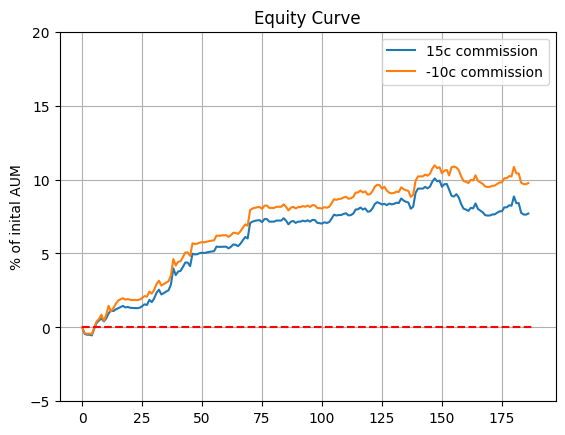

In [10]:
plt.title("Equity Curve")
plt.grid()
plt.plot(pd.Series(PNLs).dropna().cumsum().values.astype(float) / (6.5 * 1e6) * 100, label = "15c commission")
plt.plot(pd.Series(PNLs2).dropna().cumsum().values.astype(float) / (6.5 * 1e6) * 100, label = "-10c commission")
plt.hlines(y = 0, xmin = 0, xmax = len(PNLs2), linestyle = "--", color = "red")
plt.legend()
plt.ylabel("% of inital AUM")
plt.ylim(-5, 20)